## Draw point in image

In [1]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display

In [3]:
def draw_points(image, points):
    idx = -1
    for pt in points:
        idx += 1
        pt = (int(pt[0]), int(pt[1]))
        cv2.circle(image, pt, 5, (255,0,0), -1)
        cv2.putText(image, str(idx), pt, cv2.FONT_HERSHEY_COMPLEX, 1.0, (0,0,255))
    return image

def draw_landmarks(img, landmark):
    landmark = landmark
    lm_img = np.zeros([img.shape[0], img.shape[1], 3])
    lm_img[:] = img.astype(np.float32)
    landmark = np.round(landmark).astype(np.int32)

    for i in range(len(landmark)):
        for j in range(-1, 1):
            for k in range(-1, 1):
                if img.shape[0] - 1 - landmark[i, 1]+j > 0 and \
                        img.shape[0] - 1 - landmark[i, 1]+j < img.shape[0] and \
                        landmark[i, 0]+k > 0 and \
                        landmark[i, 0]+k < img.shape[1]:
                    lm_img[img.shape[0] - 1 - landmark[i, 1]+j, landmark[i, 0]+k,
                           :] = np.array([0, 0, 255])
    lm_img = lm_img.astype(np.uint8)

[[225.  230. ]
 [325.  237.5]
 [280.  279. ]
 [238.  346. ]
 [306.  351. ]] (5, 2)


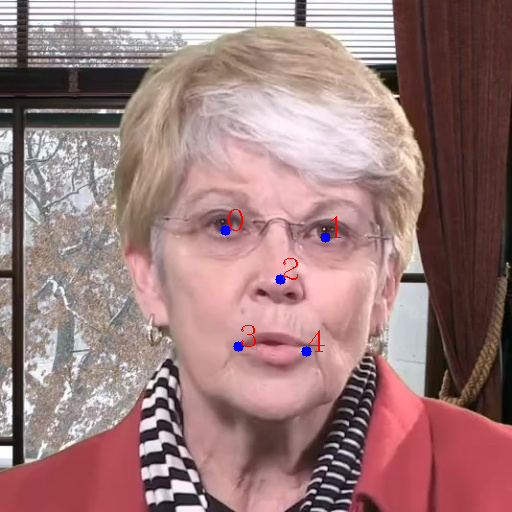

In [5]:
image_path = "/home/haimingzhang/Research/Face/Deep3DFaceReconstruction/input/vd025.png"
landmark_path = "/home/haimingzhang/Research/Face/Deep3DFaceReconstruction/input/vd025.txt"

image_path = "/home/haimingzhang/Research/Programming/cv-fighter/face_fighter/gangqiang-2-512x512/000001.jpg"
landmark_path = "/home/haimingzhang/Research/Programming/cv-fighter/face_fighter/gangqiang-2-512x512/000001.txt"

image_path = "/home/haimingzhang/Research/Deep3DFaceRecon_pytorch/datasets/examples/000002.jpg"
landmark_path = "/home/haimingzhang/Research/Deep3DFaceRecon_pytorch/datasets/examples/detections/000002.txt"

image_path = "/home/haimingzhang/Research/Deep3DFaceRecon_pytorch/datasets/examples/000007.jpg"
landmark_path = "/home/haimingzhang/Research/Deep3DFaceRecon_pytorch/datasets/examples/landmarks/000007.txt"

image_path = "/home/haimingzhang/Research/Face/FaceFormer/FaceFormer/data/id00002/obama_weekly_003/face_image/000000.jpg"
landmark_path = "/home/haimingzhang/Research/Face/FaceFormer/FaceFormer/data/id00002/obama_weekly_003/face_image/000000.txt"

image_path = "/home/zhanghm/Research/VideoMAE/VideoMAE/data/HDTF_preprocessed/RD_Radio1_000/face_image/remove/000000.jpg"
landmark_path = "/home/zhanghm/Research/StyleGAN/Deep3DFaceRecon_pytorch/temp.txt"

img_src = cv2.imread(image_path)
# display(Image.fromarray(img_src[..., ::-1]))

landmarks = np.loadtxt(landmark_path)
print(landmarks, landmarks.shape)

draw_points(img_src, landmarks)
display(Image.fromarray(img_src[..., ::-1]))
